In [1]:
import re
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from pathlib import Path
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.io import imread
import torchvision
from torch.utils.data import Dataset
from snn_model.snn_dataset import *
from snn_model.model import *
from snn_model.functions import *
from snn_model.transformations import *

In [2]:
def del_empty_dirs(path: str):
    for d in os.listdir(path):
        a = os.path.join(path, d)
        if os.path.isdir(a):
            del_empty_dirs(a)
            if not os.listdir(a):
                os.rmdir(a)
                print(a, 'was deleted')
del_empty_dirs('C:/may/ML/GroupLe/grouple/data/face_detection/processed')

In [3]:
filecount=0
for dirpath, dirs, files in os.walk('C:/may/ML/GroupLe/grouple/data/face_detection/processed'):
    for filename in files:
        filecount+=1
filecount

21862

In [4]:
def walkdir(folder):
    """Walk through every files in a directory"""
    for dirpath, dirs, files in os.walk(folder):
        for filename in files:
            return str(os.path.abspath(os.path.join(dirpath, filename)))

In [6]:
import torchvision.transforms as T

composed = torchvision.transforms.Compose([T.ToTensor(),
                                           T.Resize((128, 128)),
                                           T.RandomChoice((#T.Grayscale(), 
                                                          T.ColorJitter(0.1, 0.1, 0.1),
                                                          T.RandomRotation(degrees=(0, 60)),
                                                          EmptyTransformation())
                                                          )])

In [7]:
import torchvision
siamse_dataset = SiamseDatasetPath(Path('C:/may/ML/GroupLe/grouple/data/face_detection/processed'), transform = composed)

100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [01:10<00:00,  4.01it/s]


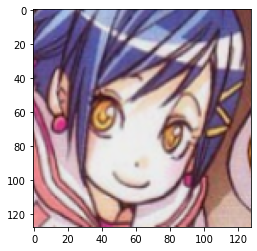

In [8]:
pic = siamse_dataset.__getitem__(1)[1]
plt.imshow(pic.permute(1, 2, 0))

In [9]:
siamse_dataset_train, siamse_dataset_test = torch.utils.data.random_split(siamse_dataset,
                                                                         (round(len(siamse_dataset)*0.8),
                                                                          int(len(siamse_dataset)*0.2)))

In [11]:
from torch.utils.data import DataLoader
batch_size = 10
train_dl = DataLoader(siamse_dataset_train, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(siamse_dataset_test, batch_size = batch_size, shuffle = True)

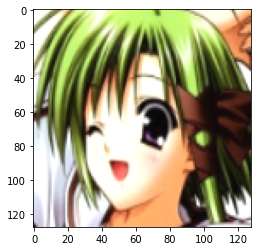

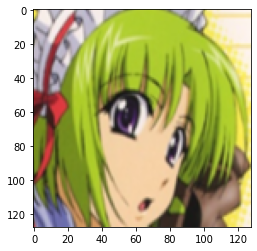

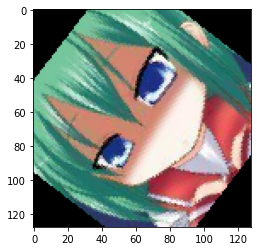

1749
438


In [12]:
for i in train_dl:
    plt.imshow(i[0][0].permute(1, 2, 0))#anchor
    plt.show()
    plt.imshow(i[1][0].permute(1, 2, 0)) #positive
    plt.show()
    plt.imshow(i[2][0].permute(1, 2, 0)) #negative
    plt.show()
    break
    
print(len(train_dl))
print(len(test_dl))

In [13]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)

In [14]:
margin = 1
loss = TripletLoss(margin)

In [15]:
from torch.utils.tensorboard import SummaryWriter

In [16]:
from statistics import mean

def train_model(model, epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
    writer = SummaryWriter('runs')
    
    for epoch in range(epochs):
        
        print('\n\n')
        print('------- EPOCH', epoch, '--------' )
        
        train_prebs_history = []
        train_loss_history = []
        train_accuracy_history = []
        
        test_accuracy_history = []
        test_preds_history = []
        test_loss_history = []
        
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(train_dl), total = len(train_dl)):

            optimizer.zero_grad()
            
            preds = model.forward(anchor, positive, negative)

            output = loss.forward(preds[0], preds[1], preds[2])
            train_loss_history.append(output)
            writer.add_scalar('Loss/train', output, batch_idx + (len(train_dl)/batch_size) * epoch)
            
            output.backward() #считаем градиенты
            optimizer.step() #обновляем параметры/веса
            
            cur_accuracy = accuracy(preds[0], preds[1], preds[2], batch_size)
            train_accuracy_history.append(cur_accuracy)
            writer.add_scalar('Accuracy/train', cur_accuracy, batch_idx + (len(train_dl)/batch_size) * epoch)
            
        print('train accuracy: ', mean(train_accuracy_history))
#         print('train loss: ', mean(train_loss_history))
        

        
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(test_dl), total = len(test_dl)):
            
            test_preds = model.forward(anchor, positive, negative)
            cur_accuracy = accuracy(test_preds[0], test_preds[1], test_preds[2], batch_size)
            test_accuracy_history.append(cur_accuracy)
            writer.add_scalar('Accuracy/train', cur_accuracy, batch_idx + (len(test_dl)/batch_size) * epoch)
            
            with torch.no_grad():
                test_loss = loss.forward(test_preds[0], test_preds[1], test_preds[2])
                test_loss_history.append(test_loss)
                writer.add_scalar('Loss/test', test_loss, batch_idx + (len(test_dl)/batch_size) * epoch)
                
        print('test accuracy: ', mean(test_accuracy_history))
#         print('test loss: ', mean(test_loss_history))
            

In [17]:
train_model(model)

  0%|                                                                                         | 0/1749 [00:00<?, ?it/s]




------- EPOCH 0 --------


c:\users\май\appdata\local\programs\python\python36\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
  0%|▏                                                                                | 3/1749 [00:03<35:22,  1.22s/it]


KeyboardInterrupt: 

In [896]:
from torchsummaryX import summary
for batch_idx, (a, p, n) in tqdm(enumerate(train_dl), total = len(train_dl)):
    summary(model, a, p, n)
    break

  0%|                                                                                         | 0/1749 [00:00<?, ?it/s]

torch.Size([10, 825])
torch.Size([10, 825])
torch.Size([10, 825])

  0%|                                                                                         | 0/1749 [00:00<?, ?it/s]


                                              Kernel Shape  \
Layer                                                        
0_embedding_net.conv_block1.Conv2d_0          [3, 9, 3, 3]   
1_embedding_net.conv_block1.ReLU_1                       -   
2_embedding_net.conv_block1.Conv2d_2         [9, 15, 3, 3]   
3_embedding_net.conv_block1.ReLU_3                       -   
4_embedding_net.conv_block1.MaxPool2d_4                  -   
5_embedding_net.conv_block2.Conv2d_0        [15, 18, 5, 5]   
6_embedding_net.conv_block2.ReLU_1                       -   
7_embedding_net.conv_block2.Conv2d_2        [18, 27, 5, 5]   
8_embedding_net.conv_block2.ReLU_3                       -   
9_embedding_net.conv_block2.MaxPool2d_4                  -   
10_embedding_net.conv_block2.Conv2d_5     [27, 33, 17, 17]   
11_embedding_net.conv_block2.ReLU_6                      -   
12_embedding_net.conv_block2.MaxPool2d_7                 -   
13_embedding_net.fc.Linear_0                    [825, 768]   
14_embe